**Transfer learning using GoogleNet Inception V3**

**Installed 2 libraries:**
- opencv: It supports the Inception V3 pre-trained model
- h5py:  It is a Pythonic interface to the HDF5 binary data format. It lets you store huge amounts of numerical data, and easily manipulate that data from NumPy. 


In [159]:
# Importing necessary libraries

import cv2     # Image manipulation module of OpenCV library
from keras.applications.inception_v3 import InceptionV3

In [160]:
# Import Keras Sequential model libraries

from keras.models import  Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam


In [ ]:
# Import Imgaug libraries for image augmentation
import imgaug as ia
import imgaug.augmenters as iaa

In [161]:
# Callback function libraries
# 1. For storing model with minimum loss after every epoch
from keras.callbacks import ModelCheckpoint
# 2. Stop training when val_loss does not decrease enough
from keras.callbacks import EarlyStopping
# 3. Reduce learning rate when val_loss stops improving
from keras.callbacks import ReduceLROnPlateau


In [162]:
# Misceleneous
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time

*Defining Constants*

In [163]:
img_height = 150
img_width = 150
img_channels = 3
img_dim = (img_height, img_width, img_channels)
img_size = (img_height, img_width)
batch_size = 5
epochs = 5

In [164]:
# Loading images from kaggle invasive 'train' folder 
path = "/home/ashok/Images/kaggle_invasive/train/"

In [165]:
# Reading csv file and mapping 0 & 1 to invasive and non-invasive images
train_set = pd.read_csv('/home/ashok/Documents/6.KaggleInvasive/train_labels.csv')
train_set.head()     # Ist coluumn is 'name' ie filename,
                     # IInd column is 'invasive'

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [166]:
train_set.shape 

(2295, 2)

**1.1 --- Define a function that returns:**
- A list of files with full-path
- A data frame, with filenames (with full path) & target-values
- A 1D array of labels--invasive or non-invasive


In [168]:
def load_train(path):
    # An empty list to store full filenames
    train_files = []
    # Get an array of image labels
    train_label = np.array(train_set['invasive'])
    # We need not peep into folder
    # Our filenames are 1.jpg, 2.jpg etc
    for i in range(train_set.shape[0]):
        # Create a filename with path
        filename=str(int(train_set.iloc[i,0])) +'.jpg'
        # Append it to filename list
        train_files.append(path + filename)

    # Finally replace existing values in 'name' column with filepaths
    train_set['name'] = train_files
    # Return the three objects
    return train_files, train_set, train_label


In [169]:
# Calling load_train() function
train_files, train_set, train_label = load_train(path)


In [170]:
# Filenames for invasive and non-invasive images with full path
train_files[:5]


['/home/ashok/Images/kaggle_invasive/train/1.jpg',
 '/home/ashok/Images/kaggle_invasive/train/2.jpg',
 '/home/ashok/Images/kaggle_invasive/train/3.jpg',
 '/home/ashok/Images/kaggle_invasive/train/4.jpg',
 '/home/ashok/Images/kaggle_invasive/train/5.jpg']

In [171]:
# A dataframe consisting of mapping of invasivee/non-invasive files with 0 and 1
train_set.head(5)

,name,invasive
0,/home/ashok/Images/kaggle_invasive/train/1.jpg,0
1,/home/ashok/Images/kaggle_invasive/train/2.jpg,0
2,/home/ashok/Images/kaggle_invasive/train/3.jpg,1
3,/home/ashok/Images/kaggle_invasive/train/4.jpg,0
4,/home/ashok/Images/kaggle_invasive/train/5.jpg,1


In [172]:
# train labes as 0 & 1
train_label[:5]

array([0, 0, 1, 0, 1])

In [173]:
# Split train_set into x train and y train
x_train = train_set.iloc[:2000,:]     # x_train is pandas dataframe
y_train =train_label[:2000]           # Numpy array


In [174]:
# Split validation data into x valid & y valid
x_valid = train_set.iloc[2000:,:]     # 295 images
y_valid =train_label[2000:]

**1.2 --- Constructing a simple InceptionV3 Model - base_model**

In [175]:
base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         input_shape=img_dim
                         )

**There are a total of 311 layers in this model. The layers that we will be able to see in this model:**
- mixed (Concatenate) - Concatenated 2 or more layers
- batch_normalization
- activation
- convolutional 2D
- Max pooling 2D
- average pooling 2D

**Also the huge number of trainable and non-trainable parameters:**
- Total params: 21,802,784
- Trainable params: 21,768,352
- Non-trainable params: 34,432

In [176]:
# Model Summary
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [177]:
# Total number of layers in base_model
len(base_model.layers) 

311

**Layer Names**

In [178]:
for i,layer in enumerate(base_model.layers):
    print((i,layer.name))

(0, 'input_2')
(1, 'conv2d_95')
(2, 'batch_normalization_95')
(3, 'activation_95')
(4, 'conv2d_96')
(5, 'batch_normalization_96')
(6, 'activation_96')
(7, 'conv2d_97')
(8, 'batch_normalization_97')
(9, 'activation_97')
(10, 'max_pooling2d_5')
(11, 'conv2d_98')
(12, 'batch_normalization_98')
(13, 'activation_98')
(14, 'conv2d_99')
(15, 'batch_normalization_99')
(16, 'activation_99')
(17, 'max_pooling2d_6')
(18, 'conv2d_103')
(19, 'batch_normalization_103')
(20, 'activation_103')
(21, 'conv2d_101')
(22, 'conv2d_104')
(23, 'batch_normalization_101')
(24, 'batch_normalization_104')
(25, 'activation_101')
(26, 'activation_104')
(27, 'average_pooling2d_10')
(28, 'conv2d_100')
(29, 'conv2d_102')
(30, 'conv2d_105')
(31, 'conv2d_106')
(32, 'batch_normalization_100')
(33, 'batch_normalization_102')
(34, 'batch_normalization_105')
(35, 'batch_normalization_106')
(36, 'activation_100')
(37, 'activation_102')
(38, 'activation_105')
(39, 'activation_106')
(40, 'mixed0')
(41, 'conv2d_110')
(42, 'batc

**Freeze all layers from training**

In [179]:
# 4.5 Initialise: Freeze all layers from training
for layer in base_model.layers:
    layer.trainable = False

**Make layers 300 onwards available for training.**
**Increasing training layers may reduce speed as also accuracy**

In [180]:
for layer in base_model.layers[300:]:
    layer.trainable = True

**We can see that last 12 layers which are trainable gives a status as "True"**

In [181]:
for layer in base_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

**1.3 --- Building the model further (Nested Model). As we can see "base_model" is added to Keras sequential model**

In [182]:
my_new_model = Sequential()
my_new_model.add(base_model)    # Nested model
my_new_model.add(GlobalAveragePooling2D())
my_new_model.add(Dropout(0.2))
my_new_model.add(Dense(1, activation='sigmoid'))
my_new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,561
Non-trainable params: 21,802,272
_________________________________________________________________


**The number of trainable parameters are brought down drastically from 21802784 to 2049 with the help of Global Average Pooling layer**

**1.4 --- Imgaug**

**Imgaug is another powerful Image augmentation library. It supports a wide range of augmentation techniques; some of which are demonstrated below. Detailed information available at** <href>https://imgaug.readthedocs.io/en/latest/</href>

In [183]:
# Make some images brighter and some darker.
seq1 = iaa.Sequential(iaa.Multiply((0.1, 1.2), per_channel=0.2))

# Strengthen or weaken the contrast in each image.
seq2 = iaa.Sequential(iaa.ContrastNormalization((0.1, 1.5)))

# Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them. 
    #is typically used to correct for geometric distortions or deformations that occur with non-ideal camera angles.
seq3 = iaa.Sequential(iaa.Affine(
       scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
       translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
       rotate=(-25, 25),
       shear=(-8, 8)
    ))

 # Small gaussian blur with random sigma between 0.5 and 0.75
seq4 = iaa.Sequential( iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.75))
    ))

# random crops
seq5 = iaa.Sequential(iaa.Crop(percent=(0, 0.1)))

# mirroring image
seq6 = iaa.Sequential(iaa.Flipud(1.0))

# Add gaussian noise.
seq7 = iaa.Sequential(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5))


In [184]:
# combining all separate techniques mentioned above and performing all techniques on each image in random order

seq8 = iaa.Sequential([
    iaa.Fliplr(0.5), 
    iaa.Crop(percent=(0, 0.1)), 
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
       scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
       translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
       rotate=(-25, 25),
       shear=(-8, 8)
    )
], random_order=True) 

**For understanding purpose executing each of imgaug technique separately:**

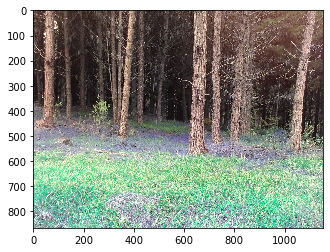

In [185]:
img = cv2.imread('/home/ashok/Images/kaggle_invasive/train/1067.jpg')
plt.imshow(img)
# Original image

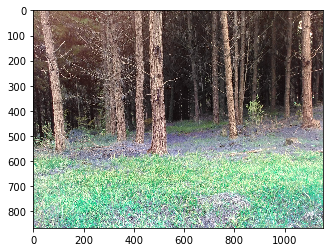

In [186]:
# Mirroring image

images_aug = seq6(images=img)
plt.imshow(images_aug)

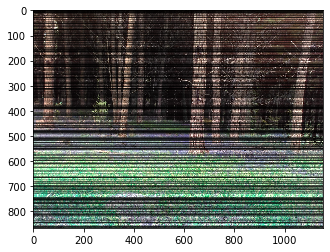

In [187]:
# Make some images brighter and some darker

images_aug = seq1(images=img)
plt.imshow(images_aug)

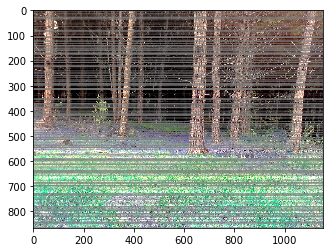

In [188]:
# Strengthen or weaken the contrast in each image.

images_aug = seq2(images=img)
plt.imshow(images_aug)

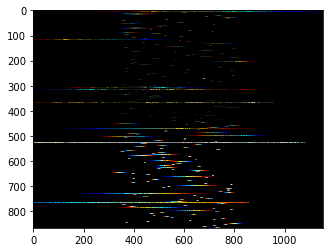

In [189]:
# Apply affine transformations to each image.
# Scale/zoom them, translate/move them, rotate them and shear them. 
#is typically used to correct for geometric distortions or deformations that occur with non-ideal camera angles.

images_aug = seq3(images=img)
plt.imshow(images_aug)

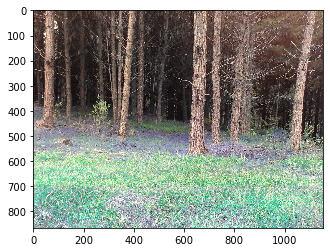

In [190]:
# Small gaussian blur with random sigma between 0.5 and 0.75

images_aug = seq4(images=img)
plt.imshow(images_aug)

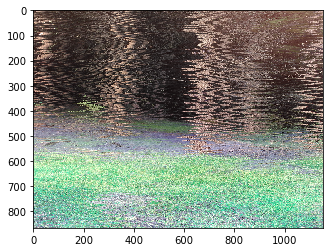

In [191]:
# random crops

images_aug = seq5(images=img)
plt.imshow(images_aug)

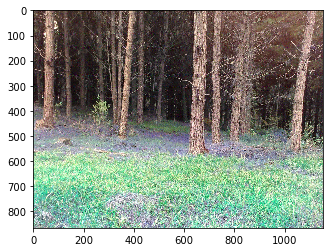

In [192]:
# Add gaussian noise

images_aug = seq7(images=img)
plt.imshow(images_aug)

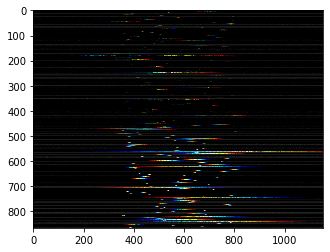

In [193]:
# Applying all imgaug techniques on an image
images_aug = seq8(images=img)
plt.imshow(images_aug)

In [194]:
# This method 'augment' together with train_generator() perform an action on the images randomly 

def imgaug_augment(src, choice):
    if choice == 0:
        images_aug = seq1(images=src)
    if choice == 1:
        images_aug = seq2(images=src)
    if choice == 2:
        images_aug = seq3(images=src)
    if choice == 3:
        images_aug = seq4(images=src)
    if choice == 4:
        images_aug = seq5(images=src)
    if choice == 5:
        images_aug = seq6(images=src)
    if choice == 6:
        images_aug = seq7(images=src)
    if choice == 7:
        images_aug = seq8(images=src) 
    return images_aug

**1.5 --- Designing Train data generator**

In [195]:
# train data generator
def train_generator():
    while True:
        # 'start' is incremented in steps of batch_size
        for start in range(0, len(x_train), batch_size):
            x_batch = []     # A list of images. Size = batch_size
            y_batch = []
            # Calculate what will be our end-point
            end = min(start + batch_size, len(x_train))
            # Read rows of data set x_train in batches
            train_batch = x_train[start:end]
            # For every filepath and target label in every row,
            for filepath, label in train_batch.values:
                # Read image of that file
                img = cv2.imread(filepath)
                # Resize image
                img = cv2.resize(img, img_size)
                # Send the image to augment() along with a
                #   random number
                img = imgaug_augment(img, np.random.randint(8))
                # Append our image to the list
                x_batch.append(img)
                y_batch.append(label)
            # Normalize images
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.uint8)
            # x_batch is a list of batch images
            # And each image is of dim (img_width,img_height,3)
            # y_batch is a 1D array
            yield x_batch, y_batch

In [197]:
# Just check by using generator
a = train_generator()
x,y = next(a)
x.shape     # (5, 75, 75, 3)
y.shape     # (5,)
x[0,...]    # Ist image, 3 channels
x[0,...].shape   # (75, 75, 3)
len(x)      # 5

(5, 150, 150, 3)

(5,)

array([[[0.39607844, 0.4392157 , 0.3372549 ],
        [0.3647059 , 0.4392157 , 0.35686275],
        [0.44313726, 0.4509804 , 0.3372549 ],
        ...,
        [0.26666668, 0.27058825, 0.23921569],
        [0.24313726, 0.23137255, 0.16078432],
        [0.3372549 , 0.34901962, 0.2509804 ]],

       [[0.47843137, 0.42745098, 0.29411766],
        [0.40784314, 0.42745098, 0.29411766],
        [0.31764707, 0.3764706 , 0.27450982],
        ...,
        [0.23529412, 0.16470589, 0.20784314],
        [0.23921569, 0.27058825, 0.16862746],
        [0.3019608 , 0.32941177, 0.20784314]],

       [[0.57254905, 0.5058824 , 0.43137255],
        [0.3882353 , 0.33333334, 0.30980393],
        [0.47058824, 0.44313726, 0.38039216],
        ...,
        [0.23529412, 0.23529412, 0.16078432],
        [0.2       , 0.19215687, 0.22745098],
        [0.23529412, 0.2509804 , 0.21176471]],

       ...,

       [[0.57254905, 0.6862745 , 0.4627451 ],
        [0.58431375, 0.8039216 , 0.5529412 ],
        [0.39215687, 0

(150, 150, 3)

5

**1.6 --- Designing Validation data generator**

In [199]:

def valid_generator():
    while True:
        for start in range(0, len(x_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(x_valid))
            valid_batch = x_valid[start:end]
            for filepath, label in valid_batch.values:
                img = cv2.imread(filepath)
                img = cv2.resize(img, img_size)
                img = imgaug_augment(img, np.random.randint(8))
                x_batch.append(img)
                y_batch.append(label)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

**1.7 --- Defining callback functions list**

In [200]:

callbacks = [
             # 1. top training when a monitored quantity has stopped improving.
             EarlyStopping(monitor='val_loss',
                           patience=3,  # number of epochs with no
                                        #  improvement after which
                                        #   training will be stopped.
                           verbose=1,
                           min_delta=1e-4 # an absolute change of less
                                          #  than min_delta, will count
                                          #    as no improvement.
                           ),
            # 2. Models often benefit from reducing
            #     learning rate by a factor of 2-10
            #     once learning stagnates.
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=1, # Reduce lr, if no imporvement by 'patience'
                                           # no of epochs
                               cooldown=1, # number of epochs to wait before resuming
                                           # normal operation after lr has been reduced.
                               verbose=1,
                               min_lr=1e-7  # lower bound on the learning rate
                               ),
             # 3.  Save the model after every epoch if val_loss reduces
             ModelCheckpoint(filepath='inception.fold' +  '.hdf5',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True
                             )
            ]


**1.8 --- Compiling Model**

In [201]:
# Compile model
my_new_model.compile(
                     optimizer=Adam(lr=1e-4),
                     loss='binary_crossentropy',
                     metrics = ['accuracy']
                     )

In [202]:
# Decide number of times to call each generator per epoch:

train_steps = len(x_train) / batch_size
valid_steps = len(x_valid) / batch_size

**1.8 --- Start Training & Plot accuracy**

In [205]:
start = time.time()
history = my_new_model.fit_generator(
                                     train_generator(),
                                     train_steps,
                                     epochs=epochs,
                                     verbose=1,
                                     callbacks=callbacks,
                                     validation_data=valid_generator(),
                                     validation_steps=valid_steps
                                     )
end = time.time()
(end-start)/60

Epoch 1/5
400/400 [==============================] - 237s 593ms/step - loss: 0.6500 - acc: 0.6195 - val_loss: 0.6809 - val_acc: 0.6068

Epoch 00001: val_loss improved from inf to 0.68085, saving model to inception.fold.hdf5
Epoch 2/5
400/400 [==============================] - 218s 544ms/step - loss: 0.6336 - acc: 0.6550 - val_loss: 0.6261 - val_acc: 0.6576

Epoch 00002: val_loss improved from 0.68085 to 0.62606, saving model to inception.fold.hdf5
Epoch 3/5
400/400 [==============================] - 250s 624ms/step - loss: 0.6058 - acc: 0.6705 - val_loss: 0.6154 - val_acc: 0.6915

Epoch 00003: val_loss improved from 0.62606 to 0.61542, saving model to inception.fold.hdf5
Epoch 4/5
400/400 [==============================] - 209s 523ms/step - loss: 0.5962 - acc: 0.6845 - val_loss: 0.6101 - val_acc: 0.6610

Epoch 00004: val_loss improved from 0.61542 to 0.61011, saving model to inception.fold.hdf5
Epoch 5/5
400/400 [==============================] - 200s 499ms/step - loss: 0.5886 - acc: 0

18.71294269959132

In [206]:
# Plot accuracy curve

def plot_learning_curve():
    val_acc = history.history['val_acc']
    tr_acc=history.history['acc']
    epochs = range(1, len(val_acc) +1)
    plt.plot(epochs,val_acc, 'b', label = "Validation accu")
    plt.plot(epochs, tr_acc, 'r', label = "Training accu")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

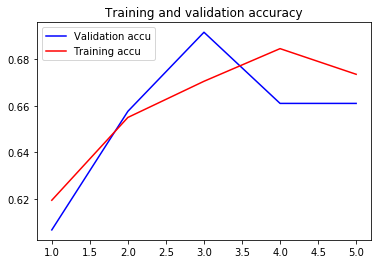

In [207]:
# 10.2 Plot training accuracy and validation accuracy
plot_learning_curve()

